In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Custom Dataset
* 고양이 5장, 개 5장이 디렉토리안에 들어있습니다.
* augmentatio은 회전, 플립, 색상 변화 3가지 있으며 zoom은 아직 구현하지 못한 상태입니다.

In [0]:
class Augment:
  # rotation
  def __init__(self, rotation, flip_left_right, flip_up_down, color, zoom):
    self.rotation = rotation
    self.flip_left_right = flip_left_right
    self.flip_up_down = flip_up_down
    self.color = color
    self.zoom = zoom

  def augmentation(self, img, size):
    if self.rotation:
      img=tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # flip_left_right
    if self.flip_left_right:
      img = tf.image.flip_left_right(image=img)

    # flip_up_down
    if self.flip_up_down:
      img = tf.image.flip_up_down(image=img)

    # color augmentation
    if self.color:
      img = tf.image.random_hue(image=img, max_delta = 0.4)
      img = tf.image.random_contrast(image=img,lower=0.7,upper=1.3)
      img = tf.image.random_saturation(image=img, lower=0.6, upper=1.6)
      img = tf.image.random_brightness(image=img, max_delta=0.05)

    # zoom
    if self.zoom:
      scales = list(np.arange(0.8, 1.0, 0.01))
      boxes = np.zeros((len(scales), 4))
      for i, scale in enumerate(scales):
          x1 = y1 = 0.5 - (0.5 * scale)
          x2 = y2 = 0.5 + (0.5 * scale)
          boxes[i] = [x1, y1, x2, y2]
      img = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(224, 224))
      choice = tf.random.uniform(shape=[], minval=0, maxval=19, dtype=tf.int64)
    return img[int(choice)]

In [0]:
class Dataset:
    def __init__(self, augment = None, path='/content/gdrive/My Drive/load_test/load_test_1', target_size=(224,224)):
      self.dir_path = path
      self.target_size = target_size
      self.Image_list = []
      self.Image_label = []
      self.augment = augment
      for index in range(len(os.listdir(self.dir_path))):
          # 클래스 라벨 추가 (고양이 : 0. , 개 : 1.)
          self.label = 1.0
          if os.listdir(self.dir_path)[index].startswith('cat'):
              self.label = 0.0
          # 이미지 경로를 저장해 나중에 배치만큼만 이미지를 불러온다.
          self.Image_list.append(os.path.join(self.dir_path, os.listdir(self.dir_path)[index]))
          # 클래스 라벨은 이미지 경로 순서대로 넣어준다.
          self.Image_label.append(self.label)
      print('Found {} images'.format(len(self.Image_list)))
    def __len__(self):
      # 이미지 경로를 담은 리스트 전체를 리턴한다.
      return len(self.Image_list)

    def __getitem__(self, idx):
      # 호출 마다 한장의 이미지와 각 클래스 라벨을 같이 넘겨준다.
      image = Image.open(self.Image_list[idx])
      image = image.resize(self.target_size)
      image = np.array(image)/255.0
      # image_augmentation
      if self.augment:
        image = self.augment.augmentation(image, self.target_size)
      #image = image.resize(self.target_size)
      return image, self.Image_label[idx]

In [0]:
class Data_Loader(Sequence):
    # __init__
    def __init__(self, dataset, batch_size=None):
      # 데이터셋을 맴버로 가지며 데이터셋을 호출해 배치만큼 사진을 가지고 온다.
      self.dataset = dataset
      self.batch_size = batch_size

    # __getitem__
    def __getitem__(self, idx):
      # 시작과 끝 인덱스 지정 --> 배치 사이즈만큼 for 루프를 실행하며 사진을 넘파이 배열에 저장한다.
      start = idx * self.batch_size
      end = (idx+1) * self.batch_size
      data = []
      label = []
      # 배치사이즈 만큼 사진과 라벨을 리스트에 저장한다.
      for j in range(start, end):
        data.append(self.dataset[j])
      # 사진은 사진끼리 라벨은 라벨끼리 묶어서 리턴한다.
      batch = tuple(np.stack(sample, axis = 0) for sample in zip(*data))
      return batch

    # __len__
    def __len__(self):
      # 데이터셋을 크기를 배치 사이즈로 나누어 준다.
        return (len(self.dataset) // self.batch_size)

# Custom VGG16 Model

*   VGG16모델을 Conv_block과 Dense_block으로 나누어 각각 클래스화 시킨후 VGG16모델을 최종적으로 만드는 클래스에서 이 두 클래스를 호출하는 함수를 호출하는 방식으로 작성하였습니다. 



In [0]:
class Conv_block(tf.keras.layers.Layer):
  def __init__(self, filter_num, name, kernel_size  = (3,3), pool_size = (2,2), strides = (2,2)):
    super(Conv_block, self).__init__()
    self.filter_num = filter_num
    self.block_conv1 = Conv2D(self.filter_num, kernel_size, activation='relu', kernel_initializer='he_uniform', padding='same', name= name+'_conv1')
    self.block_conv2 = Conv2D(self.filter_num, kernel_size, activation='relu', kernel_initializer='he_uniform', padding='same', name= name+'_conv2')
    if self.filter_num >= 256:
      self.block_conv3 = Conv2D(self.filter_num, kernel_size, activation='relu', kernel_initializer='he_uniform', padding='same', name= name+'_conv3')
    self.block_batch = BatchNormalization()
    self.block_maxpool = MaxPooling2D(pool_size, strides=strides, name='block1_pool')

  def call(self, input_image):
    x = self.block_conv1(input_image)
    x = self.block_conv2(x)
    if self.filter_num>=256:
      x = self.block_conv3(x)
    x = self.block_batch(x)
    return self.block_maxpool(x)


In [0]:
class Dense_block(tf.keras.layers.Layer):
  def __init__(self, dense_units, out_num):
    super(Dense_block, self).__init__()
    self.flatten = Flatten()
    self.dense_1024 = Dense(dense_units[0], activation='relu', kernel_initializer='he_normal')
    self.dense_drop = Dropout(0.2)
    self.den_batch1 = BatchNormalization()
    self.dense_512 = Dense(dense_units[1], activation='relu', kernel_initializer='he_normal')
    self.den_batch2 = BatchNormalization()
    self.dense_output = Dense(out_num, activation='sigmoid')

  def call(self, input_image):
    x = self.flatten(input_image)
    x = self.dense_1024(x)
    x = self.dense_drop(x)
    x = self.den_batch1(x)
    x = self.dense_512(x)
    x = self.den_batch2(x)
    return self.dense_output(x)

In [0]:
def make_Conv_block(filter_num, name):
  block = tf.keras.Sequential()
  block.add(Conv_block(filter_num, name))
  return block

In [0]:
def make_Dense_block(Dense_units, out_num):
  block = tf.keras.Sequential()
  block.add(Dense_block(Dense_units, out_num))
  return block

In [0]:
class custom_vgg16(tf.keras.Model):
  def __init__(self):
    super(custom_vgg16, self).__init__()
    self.conv_block1 = make_Conv_block(64, 'block1')
    self.conv_block2 = make_Conv_block(128, 'block2')
    self.conv_block3 = make_Conv_block(256, 'block3')
    self.conv_block4 = make_Conv_block(512, 'block4')
    self.conv_block5 = make_Conv_block(512, 'block5')
    self.dense_block = make_Dense_block([1024, 512], 1)

  def call(self, input_image):
    x = self.conv_block1(input_image)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    x = self.conv_block5(x)
    return self.dense_block(x)

In [0]:
model_vgg16 = custom_vgg16()

# 데이터 로더
* 각각 10장(고양이 5장, 개 5장)을 가지고 있는 디렉토리이며 겹치는 사진은 없습니다.


In [0]:
train_PATH = '/content/gdrive/My Drive/load_test/train'
val_PATH = '/content/gdrive/My Drive/load_test/val'
train_batch = 2
test_batch = 2

aug_dic = dict(rotation=True,
               flip_left_right = True,
               flip_up_down = True,
               color = True,
               zoom = True)

In [22]:
train_augment = Augment(**aug_dic)
train_dataset = Dataset(augment = train_augment, path=train_PATH)
train_data_gen = Data_Loader(train_dataset, train_batch)

Found 10 images


In [23]:
val_dataset = Dataset(path=val_PATH)
val_data_gen = Data_Loader(val_dataset, test_batch)

Found 10 images


* train 데이터 로더의 출력 값과 형태, 타입, 갯수(배치 사이즈)를 출력하여 확인했으며, augmentation된 사진을 확인합니다.

In [24]:
batch = train_data_gen.__getitem__(2)
print(type(batch), type(batch[0]), type(batch[1]))
print(len(batch[0]), len(batch[1]))
print(batch[0].shape, batch[1].shape)

<class 'tuple'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
2 2
(2, 224, 224, 3) (2,)


label : [0. 1.]
<class 'numpy.float64'>


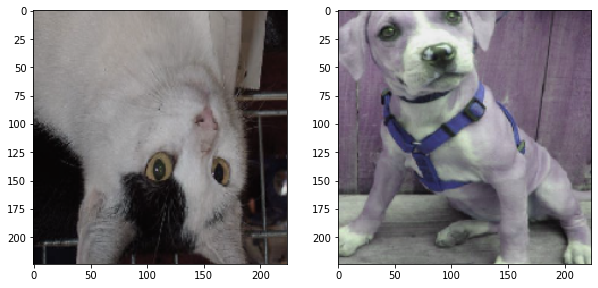

In [25]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(batch[0][0])
plt.subplot(1,2,2)
plt.imshow(batch[0][1])
print('label :', batch[1])
print(type(batch[1][0]))

# 모델 훈련  
### Using GradientTape

* 현재는 테스트용 사진이적어 epoch은 1, step은 각각 5를 사용하였습니다. 


In [26]:
from tensorflow import keras
epoches = 1
train_stpes = 5
val_steps = 5

optimize = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
loss_func = keras.losses.BinaryCrossentropy(from_logits=False)
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

for epoch in range(epoches):
  print('start epoch :', epoch+1)
  #for step, (train_data, train_label) in enumerate(train_data_gen):
  for step in range(train_stpes):
    idx = step + epoch*train_stpes
    if idx >= train_stpes*train_batch:
      idx %= (rain_stpes*train_batch)

    train_data, train_label = train_data_gen.__getitem__(idx)
    with tf.GradientTape() as tape:
      logits = model_vgg16(train_data, training=True)
      loss_value = loss_func(train_label, logits)
    grads = tape.gradient(loss_value, model_vgg16.trainable_weights)
    optimize.apply_gradients(zip(grads, model_vgg16.trainable_weights))

    train_acc_metric(train_label, logits)

    if step % 5 == 0:
      print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
      print('Seen so far: %s samples' % ((step) * 16))

  train_acc = train_acc_metric.result()
  print('train acc : %s'% (float(train_acc),))
  train_acc_metric.reset_states()

# validation
  for j in range(val_steps):
    val_idx = j+val_steps*epoch
    if val_idx >= val_steps*test_batch:
      break
    val_data, val_label = val_data_gen.__getitem__(val_idx)
    #for val_img, val_label in val_data_gen:
    val_logits = model_vgg16(val_data)
    val_acc_metric(val_label, val_logits)

  val_acc = val_acc_metric.result()
  val_acc_metric.reset_states()
  print('val acc :', float(val_acc))

start epoch : 1
Training loss (for one batch) at step 0: 0.744780957698822
Seen so far: 0 samples
train acc : 0.30000001192092896
val acc : 0.6000000238418579


In [27]:
model_vgg16.summary()

Model: "custom_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  38976     
_________________________________________________________________
sequential_1 (Sequential)    multiple                  221952    
_________________________________________________________________
sequential_2 (Sequential)    multiple                  1476352   
_________________________________________________________________
sequential_3 (Sequential)    multiple                  5901824   
_________________________________________________________________
sequential_4 (Sequential)    multiple                  7081472   
_________________________________________________________________
sequential_5 (Sequential)    multiple                  26222593  
Total params: 40,943,169
Trainable params: 40,937,153
Non-trainable params: 6,016
______________________________________